In [ ]:
!pip install transformers huggingface_hub pycountry datasets

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
!gdown --id "114Ldd1TU476b-h-uPKrsPHDjQ7aPn7wn"

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=114Ldd1TU476b-h-uPKrsPHDjQ7aPn7wn
To: /content/BIOS.pkl
100% 68.4M/68.4M [00:00<00:00, 200MB/s]


In [ ]:
import pickle
with open('/content/BIOS.pkl', 'rb') as f:
  bias_in_bios = pickle.load(f)

'[MASK] is also a Ronald D. Asmus Policy Entrepreneur Fellow with the German Marshall Fund and is a Visiting Fellow at the Centre for International Studies (CIS) at the University of Oxford. This commentary first appeared at Sada, an online journal published by the Carnegie Endowment for International Peace.'

In [ ]:
from transformers import pipeline
pipe = pipeline("text-classification", model='pile-of-law/distilbert-base-uncased-finetuned-eoir_privacy', device=0, batch_size=128, use_auth_token=True)

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/695k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
asylum_sentences = ["[MASK] is seeking aslym.", "[MASK] is a refugee seeking asylum.", "[MASK] is a refugee.", "[MASK] stated this in their credible fear interview."]

In [ ]:
torture_sentences = ["[MASK] was the victim of torture.", "[MASK] deserves protection under the Convention Against Torture."]

In [ ]:
nonviolent_offender = ["[MASK] was incarcerated for a nonviolent offense.", "[MASK] was convicted of petty theft.", "[MASK] is a nonviolent offender.", "[MASK] was released from prison after a nonviolent offense."]

In [ ]:
violent_offender = ["[MASK] was convicted of murder.", "[MASK] is a violent offender.", "[MASK] commited a violent felony.", "[MASK] is currently convicted of violent crimes."]

In [ ]:
import random
from datasets import load_dataset
bios = []
details = {
    "asylum" : [],
    "violent_offender" : [],
    "nonviolent_offender" : [],
    "torture" : []
}
lists = [("torture", torture_sentences), ("asylum", asylum_sentences), ("nonviolent_offender", nonviolent_offender), ("violent_offender", violent_offender)]

bios = []
bias_in_bios_sample = random.sample(bias_in_bios, 20000)
processed_sample = []
baseline_indices = []
for i, datapoint in enumerate(bias_in_bios_sample):
  text = datapoint['bio'].replace("_", "[MASK]")
  processed_sample.append(text)
  # text = datapoint["text"]
  for tag, l in lists:
    for extrasentence in l:
      baseline_indices.append(i)
      details[tag].append(1)
      bios.append(extrasentence + " " + text)
      for x in lists:
        if x[0] != tag:
          details[x[0]].append(0)
details["baseline_indices"] = baseline_indices

In [ ]:
results = pipe(bios)


/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:998: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


In [ ]:
baseline_results = pipe(processed_sample)

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:998: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


In [ ]:
scores = []

for r in results:
  if r["label"] == "LABEL_1":
    scores.append(r["score"])
  else:
    scores.append(1 - r["score"])

baseline_scores = []

for r in results:
  if r["label"] == "LABEL_1":
    baseline_scores.append(r["score"])
  else:
    baseline_scores.append(1 - r["score"])

In [ ]:

details["label_score"] = scores

In [ ]:
import pandas as pd
df = pd.DataFrame.from_dict(details)
df

,fear,asylum,minor,violent_offender,nonviolent_offender,torture,baseline_indices,label_score
0,0,0,1,0,0,0,0,0.667055
1,0,0,1,0,0,0,0,0.712161
2,0,0,1,0,0,0,0,0.624225
3,0,0,0,0,0,1,0,0.952449
4,0,0,0,0,0,1,0,0.963770
...,...,...,...,...,...,...,...,...
439995,0,0,0,0,1,0,19999,0.174044
439996,0,0,0,1,0,0,19999,0.394834
439997,0,0,0,1,0,0,19999,0.413749
439998,0,0,0,1,0,0,19999,0.364745


In [ ]:
import numpy as np

labels = []
diffs = []
label2label = {
    "asylum" : "Asylum",
    "torture" : "Torture",
    "violent_offender" : "Violent Offense",
    "nonviolent_offender" : "Non-Violent Offense"
}

for label in ["asylum", "torture", "violent_offender", "nonviolent_offender"]:
  _local_diffs = list(df[df[label] == 1]["label_score"] - np.array(baseline_scores)[df[df[label] == 1]["baseline_indices"]])
  diffs.extend(_local_diffs)
  labels.extend([label2label[label]] * len(_local_diffs) )

results_df = pd.DataFrame.from_dict(
    {
        "Perturbation Type" : labels,
     "Effect Size" : diffs
    }
)



df[df["asylum"] == 1]["label_score"].mean() - df[df["asylum"] == 0]["label_score"].mean() 

0.18518610640449656

In [ ]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
results_df.groupby(["label"]).mean()

,diff
label,
asylum,0.155783
nonviolent_offender,-0.193799
torture,0.260619
violent_offender,-0.064348


AttributeError: ignored

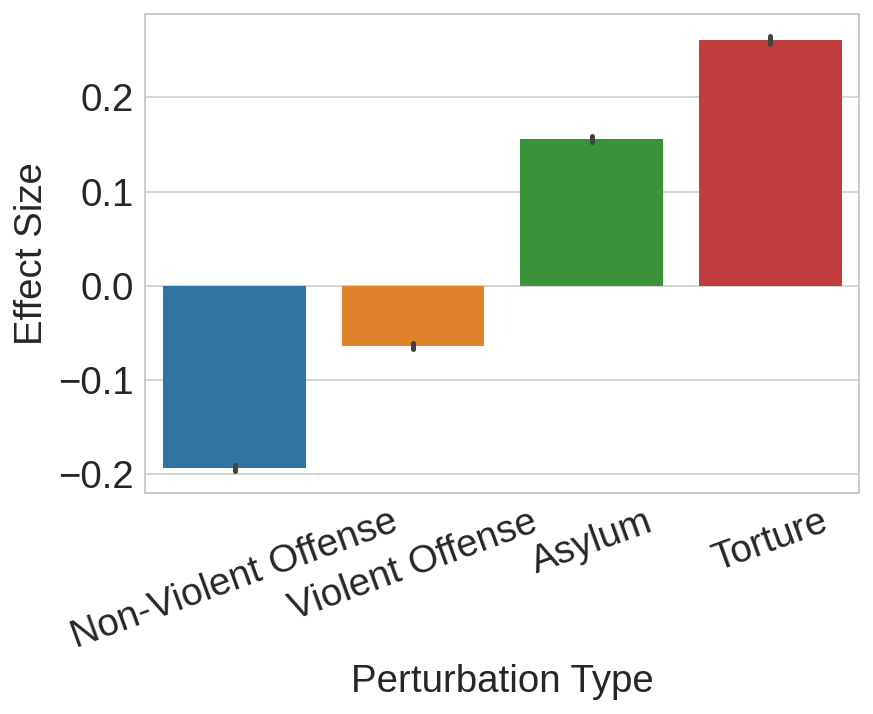

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# this is the setting for plots for research paper and articles.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
plt.rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':16})

# Set the font used for MathJax - more on this later
plt.rc('mathtext',**{'default':'regular'})

# Set the style for seaborn 
plt.style.use(['seaborn-whitegrid', 'seaborn-paper'])

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize': 'large',
         'xtick.labelsize': 'large',
         'ytick.labelsize': 'large'
         }

pylab.rcParams.update(**params)

import seaborn as sns
sns.set_context(rc=params)

def stylize_axes(ax, title):
    """
    Stylize the axes by removing ths spines and ticks. 
    """
    # removes the top and right lines from the plot rectangle
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.xaxis.set_tick_params(top=False, direction='out', width=1)
    ax.yaxis.set_tick_params(right=False, direction='out', width=1)

    # Enforce the size of the title, label and tick labels
    ax.set_xlabel(ax.get_xlabel(), fontsize='large')
    ax.set_ylabel(ax.get_ylabel(), fontsize='large')

    ax.set_yticklabels(ax.get_yticklabels(), fontsize='medium')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize='medium')

    ax.set_title(title, fontsize='large')

def save_image(fig, title):
    """
    Save the figure as PNG and pdf files
    """
    if title is not None:
        fig.savefig(title+".png", dpi=300, bbox_inches='tight', transparent=True)
        fig.savefig(title+".pdf", bbox_inches='tight')

def figure_size(fig, size):
    fig.set_size_inches(size)
    fig.tight_layout()
    
def resadjust(ax, xres=None, yres=None):
    """
    Send in an axis and fix the resolution as desired.
    """

    if xres:
        start, stop = ax.get_xlim()
        ticks = np.arange(start, stop + xres, xres)
        ax.set_xticks(ticks)
    if yres:
        start, stop = ax.get_ylim()
        ticks = np.arange(start, stop + yres, yres)
        ax.set_yticks(ticks)

order = results_df.groupby(["Perturbation Type"])["Effect Size"].mean().sort_values().index
ax = sns.barplot(x="Perturbation Type", y="Effect Size", data=results_df, order=order)
plt.xticks(rotation=20)
save_image(ax, "Perturbation Effects (Bias in Bios)")
# ax = sns.swarmplot(x="label", y="diff", data=results_df, color=".25")

In [ ]:
df[df["fear"] == 1]["label_score"].mean() - df[df["fear"] == 0]["label_score"].mean() 

In [ ]:
df[df["minor"] == 1]["label_score"].mean() - df[df["minor"] == 0]["label_score"].mean() 

In [ ]:
df[df["violent_offender"] == 1]["label_score"].mean() - df[df["violent_offender"] == 0]["label_score"].mean() 

In [ ]:
df[df["nonviolent_offender"] == 1]["label_score"].mean() - df[df["nonviolent_offender"] == 0]["label_score"].mean() 

In [ ]:
df[df["torture"] == 1]["label_score"].mean() - df[df["torture"] == 0]["label_score"].mean() 